In [2]:
using Plots
using Random
using LinearAlgebra
using CSV 
using DataFrames
using StatsPlots
using Printf
using Statistics
using BenchmarkTools
using Distributions
using LsqFit
using Colors
using ColorSchemes

[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
[ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
[ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]


In [3]:
# x[i]に比例する確率でiを返す確率変数
function サンプリング(x)
    p = x./sum(x) # 規格化された確率分布
    P = [p[1]] # 累積確率分布
    for i in 2:length(p)
        push!(P, P[i-1]+p[i])
    end
    
    q = rand()
    for i in 1:length(P)
        if q < P[i]
            return i
        end
    end
end

サンプリング (generic function with 1 method)

In [4]:
function 環境遷移(E)
    if E == 1
        return 2
    elseif E == 2
        return 1
    else
        return false
    end
end

環境遷移 (generic function with 1 method)

In [5]:
# E = 1,2 の間を時間間隔τ で往復する
function 環境の更新(Ep, dt)
    E,τE, I,τ = Ep # 環境のパラメータを解凍
    # Eは現在の環境
    # τEは現在の環境に変わってからの経過時間
    # Iは環境のストレスの強さ
    # τは1つの環境の持続時間
    
    if τE ≥ τ - 2*dt # 持続時間を過ぎたならば
        E = 環境遷移(E)
        τE = 0 # タイマーをリセット
    else
        τE += dt # 環境Eにおける経過時間を増やす
    end
    
    Ep = E,τE, I,τ # パラメータをタプルにまとめる
    return Ep
end

環境の更新 (generic function with 1 method)

In [6]:
# 環境ダイナミクスのデモンストレーション
E = 1
τE = 0
I = 1.0
τ = 1.0

Ep = E,τE, I,τ

dt = 0.1
for t = 0.0:dt:5.0
    print("t = $t    ")
    E,τE, I,τ = Ep
    println("E = $E, τE = $(τE)")
    Ep = 環境の更新(Ep, dt)
end

t = 0.0    E = 1, τE = 0
t = 0.1    E = 1, τE = 0.1
t = 0.2    E = 1, τE = 0.2
t = 0.3    E = 1, τE = 0.30000000000000004
t = 0.4    E = 1, τE = 0.4
t = 0.5    E = 1, τE = 0.5
t = 0.6    E = 1, τE = 0.6
t = 0.7    E = 1, τE = 0.7
t = 0.8    E = 1, τE = 0.7999999999999999
t = 0.9    E = 1, τE = 0.8999999999999999
t = 1.0    E = 2, τE = 0
t = 1.1    E = 2, τE = 0.1
t = 1.2    E = 2, τE = 0.2
t = 1.3    E = 2, τE = 0.30000000000000004
t = 1.4    E = 2, τE = 0.4
t = 1.5    E = 2, τE = 0.5
t = 1.6    E = 2, τE = 0.6
t = 1.7    E = 2, τE = 0.7
t = 1.8    E = 2, τE = 0.7999999999999999
t = 1.9    E = 2, τE = 0.8999999999999999
t = 2.0    E = 1, τE = 0
t = 2.1    E = 1, τE = 0.1
t = 2.2    E = 1, τE = 0.2
t = 2.3    E = 1, τE = 0.30000000000000004
t = 2.4    E = 1, τE = 0.4
t = 2.5    E = 1, τE = 0.5
t = 2.6    E = 1, τE = 0.6
t = 2.7    E = 1, τE = 0.7
t = 2.8    E = 1, τE = 0.7999999999999999
t = 2.9    E = 1, τE = 0.8999999999999999
t = 3.0    E = 2, τE = 0
t = 3.1    E = 2, τE = 0.1
t = 3.

In [7]:
function 新種の繁殖率(Ep)
    b0 = 1.0
    bs = [b0 for E in 1:2] # 出生率は全ての環境で同じであると仮定
    return bs
end

新種の繁殖率 (generic function with 1 method)

In [8]:
function 適応コストを死亡率に変換(I, cs)
    ds = I*(1.0 .- cs) # 死亡率は環境のストレス強度に比例し、適応コストが高いほど死ににくくなる
    return ds
end

function 死亡率を適応コストに変換(I, ds) # 上の関数の逆変換
    cs = 1.0 .- ds./I
    return cs
end

死亡率を適応コストに変換 (generic function with 1 method)

In [9]:
function 新種の死亡率(Ep)
    E,τE, I,τ = Ep # 環境のパラメータを解凍
    
    x = rand()
    cs = [x, 1-x] # cs[E] は、種sが環境Eに適応するのに費やした生理生態学的コスト
    
    ds = 適応コストを死亡率に変換(I, cs)
    
    return ds
end

新種の死亡率 (generic function with 1 method)

In [10]:
# 出生率、死亡率のデモンストレーション
E = 1
τE = 0
I = 2.0
τ = 1.0

Ep = E,τE, I,τ

bs = 新種の繁殖率(Ep)
ds = 新種の死亡率(Ep)
cs = 死亡率を適応コストに変換(I, ds)
println("bs = $(bs)")
println("ds = $(ds)")
println("cs = $(cs)")

bs = [1.0, 1.0]
ds = [0.9985358757203819, 1.001464124279618]
cs = [0.500732062139809, 0.49926793786019097]


In [11]:
# 初期状態 Ep,Bp を生成する
function 初期状態の生成(I,τ, L, ν)
    # Γ[x,y] は格子点(x,y)にいる種の番号。Γ[x,y] = 0 は空きパッチを表す
    # S はこれまでに登場した種の数(現在盤面上にいないものも含めた累計)
    # A[s] は種sの積算存在量 (パッチ数×存在時間)
    # b,d は種番号sをキーとして、種sの出生率,死亡率を返す辞書
    # (b[s])[E] は 種sの環境Eにおける繁殖率、(d[s])[E] は 種sの環境Eにおける死亡率
    # L は盤面のサイズ
    # ν は種分化率
    
    Γ = zeros(Int,L,L) # L×L の何もいない盤面
    S = 0
    A = Dict{Int, Float64}()
    b = Dict{Int,Vector{Float64}}()
    d = Dict{Int,Vector{Float64}}()
    
    S_ini = 10
    S = S_ini
    
    # 盤面の用意
    for x = 1:L, y = 1:L
        Γ[x,y] = rand(1:S_ini)# S_ini 種がランダムにパッチを埋め尽くしている状態
    end
    
    E = 1 # 最初は E=1 から開始
    τE = 0 # タイマーをリセット
    Ep = E,τE, I,τ # 環境のパラメータをまとめる
    
    # 繁殖率,死亡率, 積算存在量 の用意
    for s in 1:S_ini
        b[s] = 新種の繁殖率(Ep)
        d[s] = 新種の死亡率(Ep)
        A[s] = 0
    end
    
    Bp = Γ, S, A, b, d, L, ν # 生物群集のパラメータをまとめる
    
    return Ep, Bp
end

初期状態の生成 (generic function with 1 method)

In [34]:
function 種番号を色名に変換(s, Ep, Bp)
    E,τE, I,τ = Ep # 環境のパラメータを解凍
    Γ, S, A, b, d, L, ν = Bp # 生物群集のパラメータを解凍
    
    if s == 0
        return "white" # 空きパッチは白
    else # 何らかの種がいる場合
        cp = palette(:tab20)
        return cp[(s-1)%length(cp)+1] # 異なる種を異なる色で表現
    end
end

種番号を色名に変換 (generic function with 1 method)

In [35]:
palette(:tab20) # 盤面の描画に使用する色のデモンストレーション

In [36]:
# 左下の点の座標が(x,y),幅w,高さh の長方形
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

rectangle (generic function with 1 method)

In [37]:
function 盤面の可視化(Ep, Bp, t)
    E,τE, I,τ = Ep # 環境のパラメータを解凍
    Γ, S, A, b, d, L, ν = Bp # 生物群集のパラメータを解凍
    
    plt = plot(aspect_ratio = 1, axis = false, ticks = false)
    
    # 生態系盤面の描画
    for x = 1:L, y = 1:L # 1つずつ正方形を描画していく
        s = Γ[x,y]
        c = 種番号を色名に変換(s, Ep, Bp)
        plot!(plt, rectangle(1, 1, x, y), color=c, label="")
    end
    
    # 現在の環境の可視化
    w = Int(floor(L/5))
    h = Int(floor(L/2))
    if E == 1
        plot!(plt, rectangle(w,h, L+w, h+1), color="red", label="")
        plot!(plt, rectangle(w,h, L+w, 1), color="white", label="")
    elseif E == 2
        plot!(plt, rectangle(w,h, L+w, h+1), color="white", label="")
        plot!(plt, rectangle(w,h, L+w, 1), color="blue", label="")
    end
    
    plot!(plt, title = "I = $I, τ = $τ, L = $L, ν = $ν,\nE = $E, t = "*@sprintf("%6.2f", t)*"\n\n")
    
    return plt
end

盤面の可視化 (generic function with 1 method)

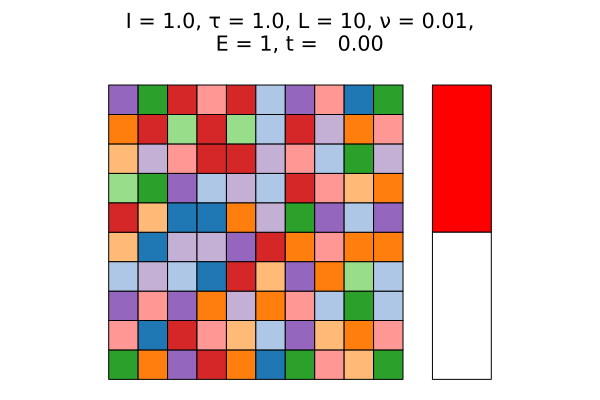

In [38]:
# 初期状態の生成のデモンストレーション
I = 1.0
τ = 1.0
L = 10
ν = 0.01

Ep, Bp = 初期状態の生成(I,τ, L, ν)

t = 0.0
dt = 0.1

盤面の可視化(Ep, Bp, t)

In [17]:
function pbc(x, L) # x に周期境界条件を課して、1以上L以下の範囲に納める
    if x < 1
        return x+L
    elseif x > L
        return x-L
    else
        return x
    end
end

pbc (generic function with 1 method)

In [18]:
# L×L の二次元正方格子において 格子点(x,y)の上下左右の最近接格子点の座標を返す(周期境界条件)
function 最近接格子点(x,y, L)
    nn = [pbc.([x+1,y],L), pbc.([x-1,y],L), pbc.([x,y+1],L), pbc.([x,y-1],L)]
    return nn
end

最近接格子点 (generic function with 1 method)

In [19]:
function 空きパッチの座標リスト(Γ, x,y)
    L = size(Γ)[1] # 盤面のサイズは L×L
    nn = 最近接格子点(x,y, L) # (x,y)の上下左右にある格子点の座標リスト(周期境界)
    
    empty = [z for z in nn if Γ[z[1],z[2]]==0] # 空きパッチの座標リスト
    
    return empty
end

空きパッチの座標リスト (generic function with 1 method)

In [20]:
function 積算存在量を更新(Bp, dt)
    Γ, S, A, b, d, L, ν = Bp # 生物群集のパラメータを解凍
    
    for x = 1:L, y = 1:L # 全てのパッチを1つずつチェック
        s = Γ[x,y] # 格子点(x,y)にいる種の番号を取得
        if s ≠ 0 # 何か種がいるとき
            if haskey(A, s) # 既に登録済みの種の場合
                A[s] += dt
            else # 未登録の種の場合
                A[s] = dt # 新しい辞書要素を追加
            end
        end
    end
    
    Bp = Γ, S, A, b, d, L, ν
    return Bp
end

積算存在量を更新 (generic function with 1 method)

In [21]:
# 格子点(x,y)を更新する
function パッチ1つを更新(Ep, Bp, x,y, dt)
    E,τE, I,τ = Ep # 環境のパラメータを解凍
    Γ, S, A, b, d, L, ν = Bp # 生物群集のパラメータを解凍
    
    s = Γ[x,y] # 格子点(x,y)にいる種番号を取得 (s = 0 は空きパッチ)

    
    # 吸収状態があるダイナミクス 
    if s ≠ 0 # 格子点(x,y)に何か種がいるとき
        bsE = (b[s])[E]
        dsE = (d[s])[E]
        # 繁殖イベント
        empty = 空きパッチの座標リスト(Γ, x,y)
        if !isempty(empty) # (x,y)の上下左右に少なくとも1つの空きパッチがある場合
            if rand() < bsE*dt # レート bsE で繁殖イベント発生
                z = rand(empty) # 個体を送り込む空きパッチをランダムに選ぶ
                if rand() < ν # 確率νで種分化
                    s_new = S+1 # まだ1度も使ったことがない種番号
                    S += 1 # これまでに登場した種の数を1増やす
                    b[s_new] = 新種の繁殖率(Ep)
                    d[s_new] = 新種の死亡率(Ep)
                    Γ[z[1],z[2]] = s_new
                else # 確率(1-ν)で通常の増殖
                    Γ[z[1],z[2]] = s
                end
            end
        end
        
        # 死亡イベント
        if rand() < dsE*dt # レート dsE で死亡イベント発生
            Γ[x,y] = 0 # 座標(x,y)にいた個体が死亡し、空きパッチになる
        end
        
    end

    Bp = Γ, S, A, b, d, L, ν # タプルにまとめる
    return Ep, Bp
end

パッチ1つを更新 (generic function with 1 method)

In [22]:
# ランダムに座標(x,y)を選んでそのパッチを更新する操作を L×L回繰り返す
function 盤面1周分更新(Ep, Bp, dt)
    E,τE, I,τ = Ep # 環境のパラメータを解凍
    Γ, S, A, b, d, L, ν = Bp # 生物群集のパラメータを解凍
    
    for step = 1:L^2
        x,y = rand(1:L),rand(1:L) # ランダムに格子点を1つ選択
        Ep, Bp = パッチ1つを更新(Ep, Bp, x,y, dt) # 選択されたパッチを状態更新
    end
    
    Bp = 積算存在量を更新(Bp, dt)
    return Ep, Bp
end

盤面1周分更新 (generic function with 1 method)

In [23]:
function 環境と盤面をdtだけ時間発展(Ep, Bp, dt)
    Ep = 環境の更新(Ep, dt)
    Ep, Bp = 盤面1周分更新(Ep, Bp, dt)
    return Ep, Bp
end

環境と盤面をdtだけ時間発展 (generic function with 1 method)

In [24]:
function 時間tfシミュレーション(I,τ, L, ν, dt, tf)
    Ep, Bp = 初期状態の生成(I,τ, L, ν)
    
    t = 0.0 # 現在時刻
    while t ≤ tf
        Ep, Bp = 環境と盤面をdtだけ時間発展(Ep, Bp, dt)
        t += dt
        
        # この処理をしていいのは吸収状態がある場合に限る
        Γ = Bp[1]
        if Γ == zeros(L,L)
            break # 全ての生物種が絶滅したら、計算を打ち切る
        end
    end

    return Ep, Bp
end

時間tfシミュレーション (generic function with 1 method)

In [25]:
# 積算存在量の計算デモンストレーション
I = 1.0
τ = 5.0
L = 10
ν = 0.01
dt = 0.1
tf = 10^3
Ep, Bp = 時間tfシミュレーション(I,τ, L, ν, dt, tf)
A = Bp[3]
Avec = [A[s] for s in keys(A)]
ρ = sum(Avec)/(L^2*tf)

0.8072030000006982

In [26]:
function ファイル名(Ep, Bp)
    E,τE, I,τ = Ep # 環境のパラメータを解凍
    Γ, S, A, b, d, L, ν = Bp # 生物群集のパラメータを解凍
    
    file_name = "I=$I,τ=$τ,L=$L,ν=$ν"
    return file_name
end

ファイル名 (generic function with 1 method)

In [27]:
# t = from から t = to までの様子を N_frame コマのアニメーションにする
function アニメーション作成(I,τ,L,ν, dt, from, to, N_frame, fps)
    Ep, Bp = 初期状態の生成(I,τ, L, ν)
    
    t_frame = [from + (to-from)/N_frame*n for n in 0:N_frame] # フレームを撮影する時刻
    anim = Animation() # Animation オブジェクトの初期化
    
    t = 0.0 # 現在時刻
    while t ≤ t_frame[end]
        Ep, Bp = 環境と盤面をdtだけ時間発展(Ep, Bp, dt)
        if t ≥ t_frame[1] # 次のフレーム撮影時刻に達していたら
            plt = 盤面の可視化(Ep, Bp, t_frame[1]) # 動画を1フレーム描画
            frame(anim, plt) # 撮影したフレームをanimに追加
            deleteat!(t_frame, 1) # 撮影終了した時刻は削除
        end
        t += dt
    end
    
    file_name = ファイル名(Ep,Bp)
    gif(anim, file_name*".gif", fps=fps) # GIFアニメーションを保存
end 

アニメーション作成 (generic function with 1 method)

[ Info: Saved animation to C:\Users\ikumi\Downloads\I=1.0,τ=50.0,L=20,ν=0.01.gif


Plots.AnimatedGif("C:\\Users\\ikumi\\Downloads\\I=1.0,τ=50.0,L=20,ν=0.01.gif")
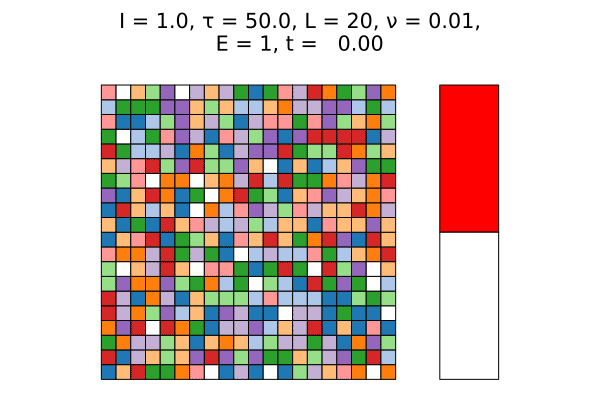

In [43]:
# アニメーション作成のデモンストレーション
I = 1.0
τ = 50.0
L = 20
ν = 0.01

dt = 0.1
from = 0
to = 500
N_frame = 200
fps = 10

アニメーション作成(I,τ,L,ν, dt, from, to, N_frame, fps)

In [28]:
function スペシャリストの割合(Bp)
    Γ, S, A, b, d, L, ν = Bp # 生物群集のパラメータを解凍

    Avec = [A[s] for s in keys(A)] # 積算存在量をベクトル化
    c = [死亡率を適応コストに変換(I, d[s]) for s in keys(A)] # それぞれの種の適応コスト
    
    sp = [var(c[i]) for i in 1:length(c)]
    
    sp_ave = dot(sp, Avec)/sum(Avec) # specializationの程度の指標
    
    return sp_ave
end

スペシャリストの割合 (generic function with 1 method)

In [29]:
function 平均占有率(Bp, tf)
    Γ, S, A, b, d, L, ν = Bp # 生物群集のパラメータを解凍
    
    Avec = [A[s] for s in keys(A)] # 積算存在量をベクトル化
    ρ = sum(Avec)/(L^2*tf)
    
    return ρ
end

平均占有率 (generic function with 1 method)

In [30]:
# 時間tfのシミュレーションをN回行って、スペシャリストの存在割合を計算する
function 与えられた環境条件で残る種の特性(I,τ, L, ν, dt, tf, N)
    Psp_list = []
    ρ_list = []
    for sample = 1:N
        Ep, Bp = 時間tfシミュレーション(I,τ, L, ν, dt, tf)
        Psp = スペシャリストの割合(Bp)
        ρ = 平均占有率(Bp, tf)
        push!(Psp_list, Psp)
        push!(ρ_list, ρ)
    end

    return Psp_list, ρ_list
end

与えられた環境条件で残る種の特性 (generic function with 1 method)

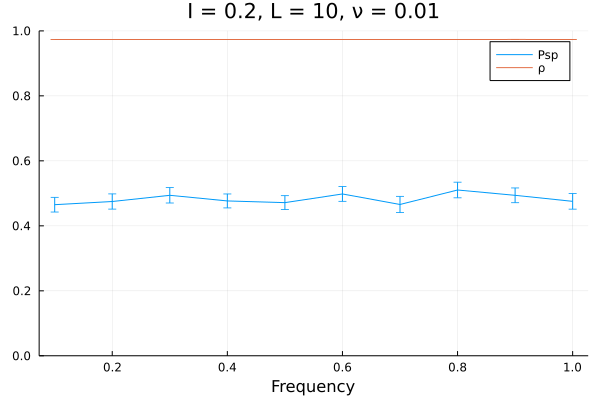

In [61]:
# ある特定のIについて、f vs Psp,ρ のグラフを描く
I = 0.2
fs = 0.01:0.01:0.10
τs = 1.0./fs
L = 10
ν = 0.01
dt = 0.1
tf = 10^3
N = 100

Psp_ave = []
Psp_err = []
ρ_ave = []
ρ_err = []

for τ in τs
    Psp_list, ρ_list = 与えられた環境条件で残る種の特性(I,τ, L, ν, dt, tf, N)
    push!(Psp_ave, mean(Psp_list))
    push!(Psp_err, std(Psp_list)/sqrt(N))
    push!(ρ_ave, mean(ρ_list))
    push!(ρ_err, std(ρ_list)/sqrt(N))
end


plt = plot(yrange=[0,1], xlabel="Frequency", title = "I = $I, L = $L, ν = $ν")
plot!(plt, fs, Psp_ave, yerror=Psp_err, markerstrokecolor=:auto, label="Psp")
plot!(plt, fs, ρ_ave, yerror=ρ_err, markerstrokecolor=:auto, label="ρ")

savefig(plt, "I=$I,L=$L,ν=$ν.svg")
plot(plt)

In [ ]:
# f-I 平面上で Pspのヒートマップとρの等高線を描く 
Is = 0.1:0.1:2.0
fs = 0.005:0.005:0.10
τs = 1.0./fs
L = 20
ν = 0.01
dt = 0.1
tf = 10^3
N = 100

Psp_ave = zeros(length(Is), length(τs))
Psp_err = zeros(length(Is), length(τs))
ρ_ave = zeros(length(Is), length(τs))
ρ_err = zeros(length(Is), length(τs))

for i in 1:length(Is), j in 1:length(τs)
    I = Is[i]
    τ = τs[j]
    Psp_list, ρ_list = 与えられた環境条件で残る種の特性(I,τ, L, ν, dt, tf, N)
    Psp_ave[i,j] = mean(Psp_list)
    Psp_err[i,j] = std(Psp_list)/sqrt(N)
    ρ_ave[i,j] = mean(ρ_list)
    ρ_err[i,j] = std(ρ_list)/sqrt(N)
end

In [ ]:
# データフレームの生成
df = DataFrame(
    I = [I for I in Is, f in fs][:],
    f = [f for I in Is, f in fs][:],
    Psp_ave = Psp_ave[:],
    Psp_err = Psp_err[:],
    ρ_ave = ρ_ave[:],
    ρ_err = ρ_err[:])

# CSV出力
CSV.write("L=$L,ν=$ν.csv", df)


plt = plot(xlabel="Frequency", ylabel="I", title = "L = $L, ν = $ν")
heatmap!(plt, fs, Is, Psp_ave, c=cgrad(:lightrainbow))
contour!(plt, fs, Is, ρ_ave, c=cgrad(:grays)) # 平均密度を等高線で重ね書き

savefig(plt, "L=$L,ν=$ν.svg")
plot(plt)

In [ ]:
for i in 1:length(Is)
    I = Is[i]
    
    plt = plot(yrange=[0,1], xlabel="Frequency", title = "I = $I, L = $L, ν = $ν")
    plot!(plt, fs, Psp_ave[i,:], yerror=Psp_err[i,:], markerstrokecolor=:auto, label="Psp")
    plot!(plt, fs, ρ_ave[i,:], yerror=ρ_err[i,:], markerstrokecolor=:auto, label="ρ")
    
    savefig(plt, "I=$I,L=$L,ν=$ν.svg")
end

In [131]:
# 時間測定用
I = 1.0
τ = 5.0
L = 20
ν = 0.01
dt = 0.1
tf = 10^2
N = 10
@time 与えられた環境条件で残る種の特性(I,τ, L, ν, dt, tf, N)

  2.184691 seconds (35.60 M allocations: 2.536 GiB, 18.73% gc time)


(Any[0.5516960583815633, 0.6607074354594642, 0.40337164181879226, 0.666311011278001, 0.4972448747921405, 0.271092488191393, 0.4930826435549887, 0.4449022676135122, 0.4279564485517846, 0.22705992796605917], Any[0.8043649999999751, 0.7885525000002641, 0.8079149999997615, 0.8013374999997269, 0.8148450000004652, 0.8203749999998045, 0.8088350000005028, 0.8099924999998531, 0.8153575000004871, 0.8148950000003069])